In [108]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import make_scorer, mean_squared_error

# modelling
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RepeatedKFold,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.svm import SVR, LinearSVR
from xgboost import XGBRegressor

plt.rcParams.update({"figure.max_open_warning": 0})

warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_colwidth", 1000)
pd.set_option("display.width", 1000)

In [3]:
train_data_file = "./zhengqi_train.txt"
test_data_file = "./zhengqi_test.txt"

data_train = pd.read_csv(train_data_file, sep="\t", encoding="utf-8")
data_test = pd.read_csv(test_data_file, sep="\t", encoding="utf-8")

### 评价函数

In [4]:
from sklearn.metrics import make_scorer


# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)
    n = len(y_pred)

    return np.sqrt(sum_sq / n)


def mse(y_ture, y_pred):
    return mean_squared_error(y_ture, y_pred)


# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)
mse_scorer = make_scorer(mse, greater_is_better=False)

### 删除无关特征

In [5]:
# 两组特征筛选，实验
# ["V5", "V9", "V11", "V17", "V22", "V28"]
# ["V5", "V9", "V11", "V17", "V22", "V28", "V14", "V21", "V25", "V26", "V32", "V33", "V34"]

In [6]:
data_train.drop(
    ["V5", "V9", "V11", "V17", "V22", "V28"],
    axis=1,
    inplace=True,
)
data_test.drop(
    ["V5", "V9", "V11", "V17", "V22", "V28"],
    axis=1,
    inplace=True,
)

### 获取异常数据

In [7]:
# function to detect outliers based on the predictions of a model
def find_outliers(model, X, y, sigma=3):

    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X, y)
        y_pred = pd.Series(model.predict(X), index=y.index)

    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid) / std_resid
    outliers = z[abs(z) > sigma].index

    # print and plot the results
    print("R2=", model.score(X, y))
    print("rmse=", rmse(y, y_pred))
    print("mse=", mean_squared_error(y, y_pred))
    print("---------------------------------------")

    print("mean of residuals:", mean_resid)
    print("std of residuals:", std_resid)
    print("---------------------------------------")

    print(len(outliers), "outliers:")
    print(outliers.tolist())

    plt.figure(figsize=(15, 5))
    ax_131 = plt.subplot(1, 3, 1)
    plt.plot(y, y_pred, ".")
    plt.plot(y.loc[outliers], y_pred.loc[outliers], "ro")
    plt.legend(["Accepted", "Outlier"])
    plt.xlabel("y")
    plt.ylabel("y_pred")

    ax_132 = plt.subplot(1, 3, 2)
    plt.plot(y, y - y_pred, ".")
    plt.plot(y.loc[outliers], y.loc[outliers] - y_pred.loc[outliers], "ro")
    plt.legend(["Accepted", "Outlier"])
    plt.xlabel("y")
    plt.ylabel("y - y_pred")

    ax_133 = plt.subplot(1, 3, 3)
    z.plot.hist(bins=50, ax=ax_133)
    z.loc[outliers].plot.hist(color="r", bins=50, ax=ax_133)
    plt.legend(["Accepted", "Outlier"])
    plt.xlabel("z")

    plt.savefig("outliers.png")

    return outliers

R2= 0.8853726563655815
rmse= 0.3330802405681946
mse= 0.11094244665696637
---------------------------------------
mean of residuals: -7.136873425265246e-17
std of residuals: 0.33313792179480556
---------------------------------------
33 outliers:
[321, 348, 376, 777, 884, 1145, 1164, 1310, 1523, 1537, 1704, 1874, 1879, 1905, 1979, 2002, 2159, 2160, 2264, 2279, 2528, 2620, 2645, 2647, 2667, 2668, 2669, 2696, 2767, 2769, 2807, 2842, 2863]


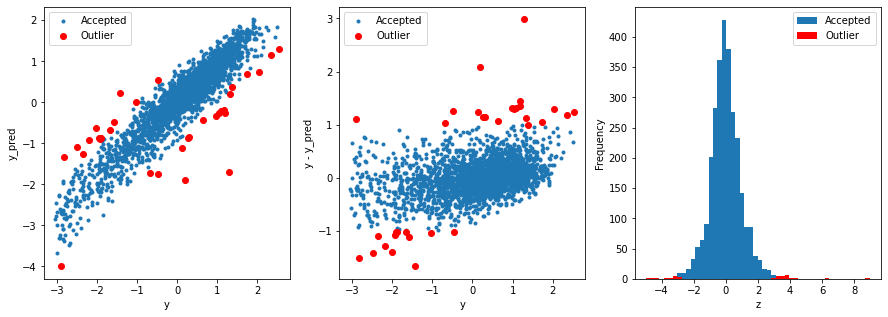

In [8]:
from sklearn.linear_model import Ridge

X_train = data_train.iloc[:, 0:-1]
y_train = data_train.iloc[:, -1]

# find and remove outliers using a Ridge model
outliers = find_outliers(Ridge(), X_train, y_train)

# permanently remove these outliers from the data
data_train.drop(outliers, inplace=True)
data_train.reset_index(inplace=True, drop=True)

### 标签数据对数变换数据，使数据更符合正态（实际效果不好）

count    2855.000000
mean        1.130203
std         0.389488
min         0.291057
25%         0.871576
50%         1.136697
75%         1.378403
max         2.759030
Name: target1, dtype: float64


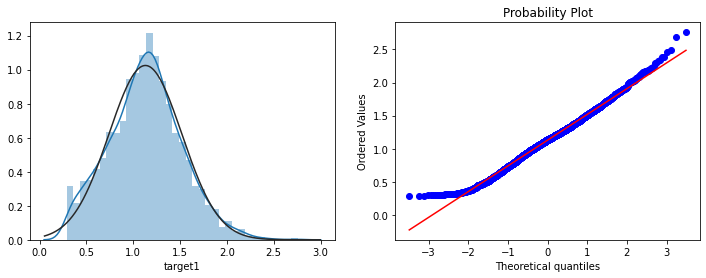

In [9]:
# Log Transform SalePrice to improve normality
sp = data_train.target
data_train["target1"] = np.power(1.5, sp)
print(data_train["target1"].describe())

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.distplot(data_train.target1.dropna(), fit=stats.norm)
plt.subplot(1, 2, 2)
_ = stats.probplot(data_train["target1"].dropna(), plot=plt)

### 多重共线性分析

In [10]:
# !pip install statsmodels -q

One recommendation is that if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.

官方文档建议：筛选出VIF（variance_inflation_factor）大于5的变量，不予使用，但是筛选动作执行在特征构造之后

同时，实际筛选标准，或者是否根据其筛选，通过实验决定

In [11]:
from statsmodels.stats.outliers_influence import (
    variance_inflation_factor,  # 多重共线性方差膨胀因子,,,,,,,,,,,,,,,,,,,,,,,,,,,
)

# droped = ["V5", "V9", "V11", "V17", "V22", "V28"]
# or
# droped = ["V5", "V9", "V11", "V17", "V22", "V28", "V14", "V21", "V25", "V26", "V32", "V33", "V34"]
# 多重共线性
new_numerical = [
    "V0",
    "V1",
    "V2",
    "V3",
    "V4",
    "V6",
    "V7",
    "V8",
    "V10",
    "V12",
    "V13",
    "V14",
    "V15",
    "V16",
    "V18",
    "V19",
    "V20",
    "V21",
    "V23",
    "V24",
    "V25",
    "V26",
    "V27",
    "V29",
    "V30",
    "V31",
    "V32",
    "V33",
    "V34",
    "V35",
    "V36",
    "V37",
]
X = np.matrix(data_train[new_numerical])
VIF_list = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
VIF_list

[17.39766768795002,
 12.902641685492341,
 11.220456231961135,
 1.918533904558704,
 13.66962930439337,
 18.909856558221847,
 11.359791621599184,
 17.351957624368477,
 9.901173429237929,
 10.568366013203832,
 3.0450579987962936,
 2.2862690739374547,
 13.508551219039406,
 16.47345883573997,
 2.225373263172099,
 1.9249872683945954,
 1.8095963805743254,
 2.0161150959007466,
 2.8581825921996193,
 2.430915460012014,
 3.9371449587359004,
 1.355408504193267,
 4.351488596834383,
 15.943498420311432,
 2.564752123064694,
 11.004182316983172,
 2.220528362387479,
 2.563621740557363,
 2.3078464829710934,
 2.4786060143638227,
 9.452890145290628,
 6.073602503541608]

### 特征构造

In [12]:
epsilon = 1e-5

# 组交叉特征，可以自行定义，如增加： x*x/y, log(x)/y 等等
func_dict = {
    "add": lambda x, y: x + y,
    "mins": lambda x, y: x - y,
    "div": lambda x, y: x / (y + epsilon),
    "multi": lambda x, y: x * y,
}

In [13]:
def auto_features_make(train_data, test_data, func_dict, col_list):
    train_data, test_data = train_data.copy(), test_data.copy()
    for col_i in col_list:
        for col_j in col_list:
            for func_name, func in func_dict.items():
                if col_i == col_j and func_name == "mins":
                    continue
                for data in [train_data, test_data]:
                    func_features = func(data[col_i], data[col_j])
                    col_func_features = "-".join([col_i, func_name, col_j])
                    data[col_func_features] = func_features
    return train_data, test_data

In [14]:
train_data2, test_data2 = auto_features_make(data_train,
                                             data_test,
                                             func_dict,
                                             col_list=data_test.columns)

In [15]:
train_data2.shape

(2855, 4098)

### PCA

In [16]:
# normalise numeric columns
train_cols_numeric = list(train_data2.columns)
print(len(train_cols_numeric))
test_cols_numeric = list(test_data2.columns)
print(len(test_cols_numeric))


def scale_minmax(col):
    return (col - col.min()) / (col.max() - col.min())


train_cols_numeric = [
    col for col in train_cols_numeric if (col != "target" and col != "target1")
]
train_data2[train_cols_numeric] = train_data2[train_cols_numeric].apply(
    scale_minmax, axis=0)
train_data2.dropna(inplace=True)

test_cols_numeric = [col for col in test_cols_numeric if col != "target"]
test_data2[test_cols_numeric] = test_data2[test_cols_numeric].apply(
    scale_minmax, axis=0)
# test_data2.fillna(value=0, inplace=True)

4098
4096


In [17]:
train_data2.shape

(2855, 4098)

In [18]:
train_data2.drop(["target", "target1"], axis=1).iloc[:, :].shape

(2855, 4096)

In [19]:
# check nan
train_data2.isna().any()[train_data2.isna().any() == True]

Series([], dtype: bool)

In [20]:
features = train_data2.drop(["target", "target1"], axis=1).iloc[:, :]
# features.describe()

features.isna().any()[features.isna().any() == True]

Series([], dtype: bool)

In [21]:
# check inf
# np.any(np.isinf(features))
for col in features.columns:
    res = features[col][np.isinf(features[col]) == True]
    if res.shape[0] != 0:
        print(res)

In [22]:
from sklearn.decomposition import PCA

# PCA方法降维
pca = PCA(n_components=16, svd_solver="full", whiten=True)

features = train_data2.drop(["target", "target1"], axis=1).iloc[:, :]

train_data2_pca = pca.fit_transform(features)
test_data2_pca = pca.transform(test_data2)
train_data2_pca = pd.DataFrame(train_data2_pca)
test_data2_pca = pd.DataFrame(test_data2_pca)

train_data2_pca["target"] = train_data2["target"]
train_data2_pca["target1"] = train_data2["target1"]

In [23]:
X = np.matrix(train_data2_pca)
VIF_list = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
VIF_list

[7.863979888216122,
 1.0521694397744021,
 1.0014376372049631,
 1.2612564992820827,
 1.0608649602085705,
 1.0848030673539475,
 1.0123724738996942,
 1.0014064617173006,
 1.0218735146612106,
 1.0030349551320588,
 1.011179230691833,
 1.0385905066429835,
 1.0029145534582438,
 1.0047455856229515,
 1.0128196089522423,
 1.0262248800080913,
 9.580713050324064,
 1.4168264803757065]

In [24]:
train_data2_pca.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 'target', 'target1'], dtype='object')

In [25]:
# 筛选VIF 大于 5 的列
# train_data2_pca.drop(0, axis=1, inplace=True)
# test_data2_pca.drop(0, axis=1, inplace=True)

# train_data2_pca.columns

In [26]:
# #merge train_set and test_set
# data_train["oringin"]="train"
# data_test["oringin"]="test"
# data_all=pd.concat([data_train,data_test],axis=0,ignore_index=True)

train_data2_pca["oringin"] = "train"
test_data2_pca["oringin"] = "test"
data_all = pd.concat([train_data2_pca, test_data2_pca],
                     axis=0,
                     ignore_index=True)

In [27]:
data_all.shape

(4780, 19)

In [28]:
cols_numeric = list(data_all.columns)
cols_numeric.remove("oringin")


def scale_minmax(col):
    return (col - col.min()) / (col.max() - col.min())


scale_cols = [
    col for col in cols_numeric if (col != "target" and col != "target1")
]
data_all[scale_cols] = data_all[scale_cols].apply(scale_minmax, axis=0)

### 特征进行Box-Cox变换，使其满足正态性

Box-Cox变换是Box和Cox在1964年提出的一种广义幂变换方法，是统计建模中常用的一种数据变换，用于连续的响应变量不满足正态分布的情况。

Box-Cox变换之后，可以一定程度上减小不可观测的误差和预测变量的相关性。Box-Cox变换的主要特点是引入一个参数，通过数据本身估计该参数进而确定应采取的数据变换形式，Box-Cox变换可以明显地改善数据的正态性、对称性和方差相等性

In [15]:
# merge train_set and test_set 不使用特征构造 和 PCA
data_train["oringin"] = "train"
data_test["oringin"] = "test"
data_all = pd.concat([data_train, data_test], axis=0, ignore_index=True)

In [16]:
data_all.columns[-3:]

Index(['target', 'target1', 'oringin'], dtype='object')

In [19]:
cols_numeric = list(data_all.columns)
cols_numeric.remove("oringin")
cols_numeric.remove("target")
cols_numeric.remove("target1")


def scale_minmax(col):
    return (col - col.min()) / (col.max() - col.min())


scale_cols = [col for col in cols_numeric]
data_all[scale_cols] = data_all[scale_cols].apply(scale_minmax, axis=0)
# data_all[scale_cols].describe()

In [20]:
cols_transform = data_all.columns[0:-3]
for col in cols_transform:
    # transform column
    data_all.loc[:, col], _ = stats.boxcox(data_all.loc[:, col] + 1)

### 划分数据

In [21]:
# function to get training samples
def get_training_data():
    # extract training samples
    from sklearn.model_selection import train_test_split

    df_train = data_all[data_all["oringin"] == "train"]
    # 没有使用 转换后的 target1
    y = df_train["target"]
    X = df_train.drop(["oringin", "target", "target1"], axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                          y,
                                                          test_size=0.2,
                                                          random_state=100)
    return X_train, X_valid, y_train, y_valid


def get_test_data():
    df_test = data_all[data_all["oringin"] == "test"].reset_index(drop=True)
    return df_test.drop(["oringin", "target", "target1"], axis=1)

In [22]:
X_train, X_valid, y_train, y_valid = get_training_data()
test = get_test_data()

### Grid Search

In [23]:
from sklearn.preprocessing import StandardScaler


def train_model(model, param_grid=[], X=[], y=[], splits=5, repeats=5):
    "Grid search使用的函数"
    # get unmodified training data, unless data to use already specified
    if len(y) == 0:
        X, y = X_train, y_train
        # poly_trans=PolynomialFeatures(degree=2)
        # X=poly_trans.fit_transform(X)
        # X=MinMaxScaler().fit_transform(X)

    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)

    # perform a grid search if param_grid given
    if len(param_grid) > 0:
        # setup grid search parameters
        gsearch = GridSearchCV(
            model,
            param_grid,
            cv=rkfold,
            scoring="neg_mean_squared_error",
            verbose=1,
            return_train_score=True,
        )

        # search the grid
        gsearch.fit(X, y)

        # extract best model from the grid
        model = gsearch.best_estimator_
        best_idx = gsearch.best_index_

        # get cv-scores for best model
        grid_results = pd.DataFrame(gsearch.cv_results_)
        cv_mean = abs(grid_results.loc[best_idx, "mean_test_score"])
        cv_std = grid_results.loc[best_idx, "std_test_score"]

    # no grid search, just cross-val score for given model
    else:
        grid_results = []
        cv_results = cross_val_score(model,
                                     X,
                                     y,
                                     scoring="neg_mean_squared_error",
                                     cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)

    # combine mean and std cv-score in to a pandas series
    cv_score = pd.Series({"mean": cv_mean, "std": cv_std})

    # predict y using the fitted model
    y_pred = model.predict(X)

    # print stats on model performance
    print("----------------------")
    print(model)
    print("----------------------")
    print("score=", model.score(X, y))
    print("rmse=", rmse(y, y_pred))
    print("mse=", mse(y, y_pred))
    print("cross_val: mean=", cv_mean, ", std=", cv_std)

    # residual plots
    y_pred = pd.Series(y_pred, index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid) / std_resid
    n_outliers = sum(abs(z) > 3)

    plt.figure(figsize=(15, 5))
    ax_131 = plt.subplot(1, 3, 1)
    plt.plot(y, y_pred, ".")
    plt.xlabel("y")
    plt.ylabel("y_pred")
    plt.title("corr = {:.3f}".format(np.corrcoef(y, y_pred)[0][1]))
    ax_132 = plt.subplot(1, 3, 2)
    plt.plot(y, y - y_pred, ".")
    plt.xlabel("y")
    plt.ylabel("y - y_pred")
    plt.title("std resid = {:.3f}".format(std_resid))

    ax_133 = plt.subplot(1, 3, 3)
    z.plot.hist(bins=50, ax=ax_133)
    plt.xlabel("z")
    plt.title("{:.0f} samples with z>3".format(n_outliers))

    return model, cv_score, grid_results

In [24]:
def plot_learning_curve(
        estimator,
        title,
        X,
        y,
        ylim=None,
        cv=None,
        n_jobs=1,
        train_sizes=np.linspace(0.1, 1.0, 5),
):
    "测试学习器的性能，并绘图"
    from sklearn.model_selection import learning_curve

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    print(train_scores_mean)
    print(test_scores_mean)

    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes,
             train_scores_mean,
             "o-",
             color="r",
             label="Training score")
    plt.plot(train_sizes,
             test_scores_mean,
             "o-",
             color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [25]:
# no. k-fold splits
splits = 5
# no. k-fold iterations
repeats = 5

In [26]:
# records
opt_models = dict()

score_models = pd.DataFrame(columns=["mean", "std"])

#### 岭回归

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:    2.6s finished


----------------------
Ridge(alpha=0.25, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------
score= 0.8916836197421196
rmse= 0.3208284341662476
mse= 0.10293088416956636
cross_val: mean= 0.10691940039818539 , std= 0.005614549356080772


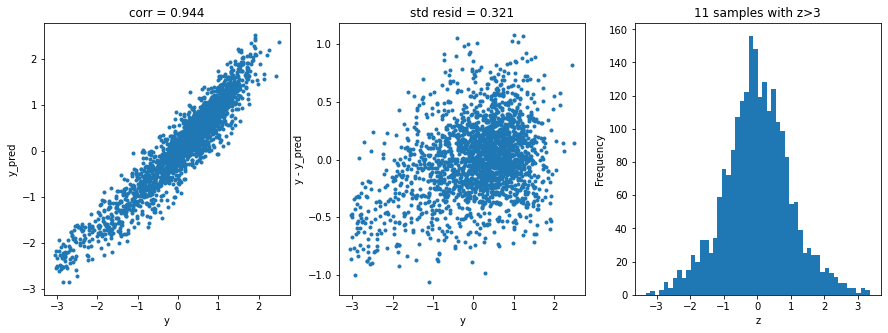

In [27]:
model = Ridge()

alph_range = np.arange(0.25, 6, 0.25)
param_grid = {"alpha": alph_range}

model, cv_score, grid_results = train_model(model,
                                            param_grid=param_grid,
                                            splits=splits,
                                            repeats=repeats)

In [28]:
cv_score.name = "ridge"
score_models = score_models.append(cv_score)
opt_models["ridge"] = model

超参数变化对结果的影响

Text(0, 0.5, 'score')

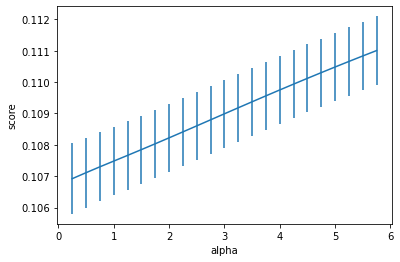

In [29]:
plt.figure()
plt.errorbar(
    alph_range,
    abs(grid_results["mean_test_score"]),
    abs(grid_results["std_test_score"]) / np.sqrt(splits * repeats),
)
plt.xlabel("alpha")
plt.ylabel("score")

#### Lasso

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:   31.7s finished


----------------------
Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.891751377301016
rmse= 0.3207280709885561
mse= 0.10286649552004021
cross_val: mean= 0.10718088914920701 , std= 0.006226580386841821


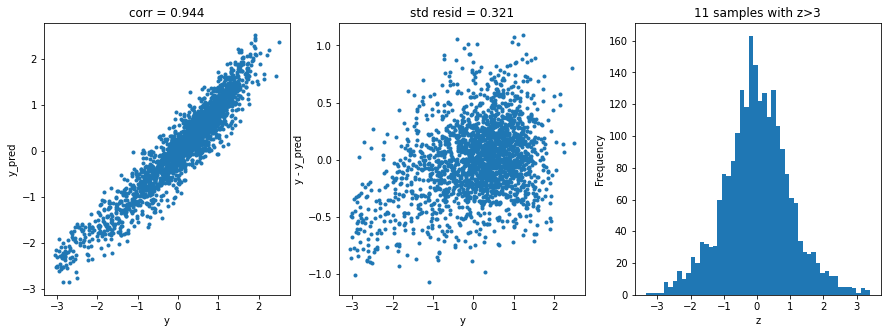

In [30]:
model = "lasso"

opt_models[model] = Lasso()
alph_range = np.arange(1e-4, 1e-3, 4e-5)
param_grid = {"alpha": alph_range}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        splits=splits,
                                                        repeats=repeats)

Text(0, 0.5, 'score')

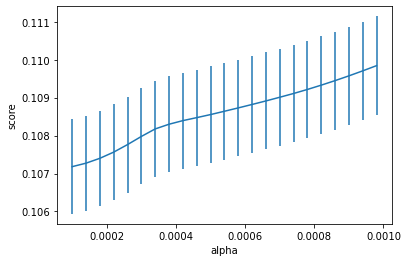

In [31]:
plt.figure()
plt.errorbar(
    alph_range,
    abs(grid_results["mean_test_score"]),
    abs(grid_results["std_test_score"]) / np.sqrt(splits * repeats),
)
plt.xlabel("alpha")
plt.ylabel("score")

#### ElasticNet

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:   23.1s finished


----------------------
ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=100000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.8917099800883834
rmse= 0.320789392687939
mse= 0.1029058344610967
cross_val: mean= 0.10810991768748514 , std= 0.004583784411646828


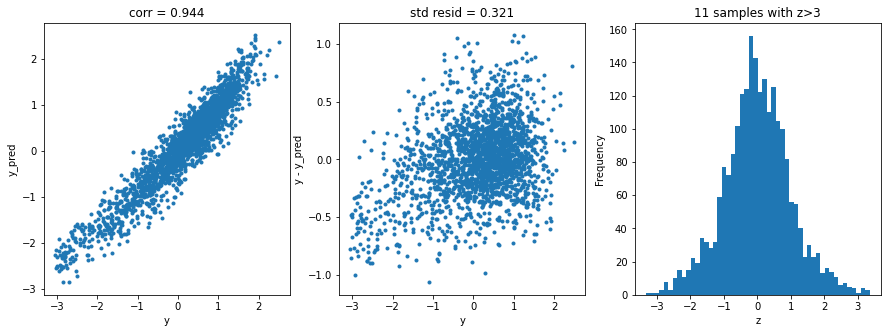

In [32]:
model = "ElasticNet"
opt_models[model] = ElasticNet()

param_grid = {
    "alpha": np.arange(1e-4, 1e-3, 1e-4),
    "l1_ratio": np.arange(0.1, 1.0, 0.1),
    "max_iter": [100000],
}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        splits=splits,
                                                        repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

#### SVR

Fitting 25 folds for each of 9 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   51.9s finished


----------------------
LinearSVR(C=0.5, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)
----------------------
score= 0.08080256292894539
rmse= 0.9346094866048472
mse= 0.8734948924517769
cross_val: mean= 1.2294896294975979 , std= 1.8573445978172707


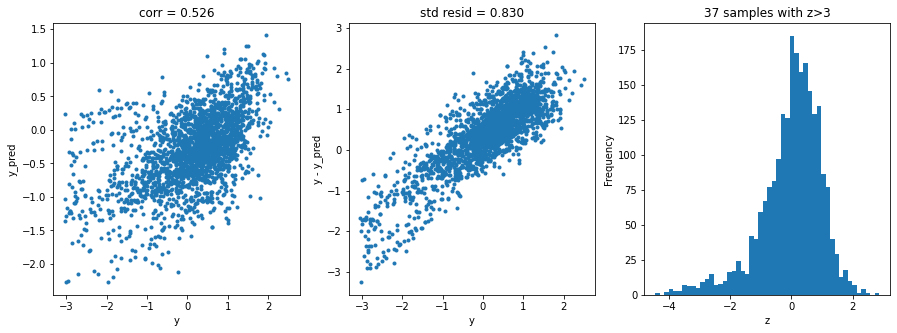

In [33]:
model = "LinearSVR"
opt_models[model] = LinearSVR()

crange = np.arange(0.1, 1.0, 0.1)
param_grid = {"C": crange, "max_iter": [1000]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        splits=splits,
                                                        repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

Text(0, 0.5, 'score')

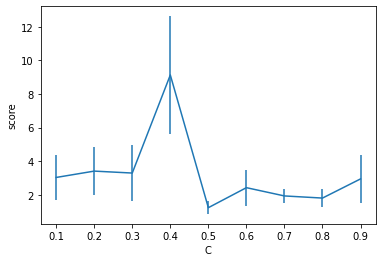

In [34]:
plt.figure()
plt.errorbar(
    crange,
    abs(grid_results["mean_test_score"]),
    abs(grid_results["std_test_score"]) / np.sqrt(splits * repeats),
)
plt.xlabel("C")
plt.ylabel("score")

#### K近邻

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.0s finished


----------------------
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')
----------------------
score= 0.7262510084535498
rmse= 0.5100374274280347
mse= 0.2601381773774081
cross_val: mean= 0.32195664672942204 , std= 0.030519911977584708


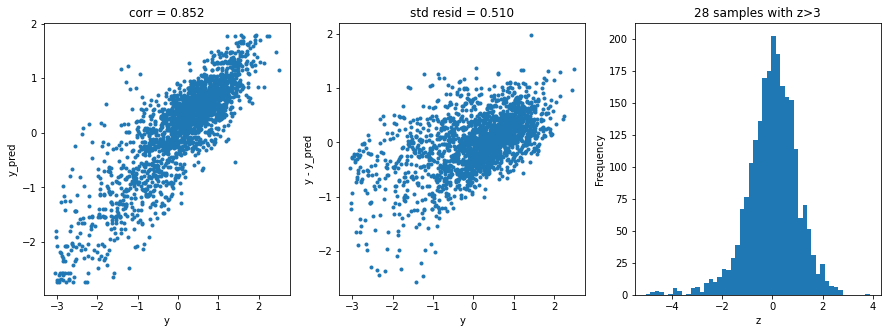

In [35]:
model = "KNeighbors"
opt_models[model] = KNeighborsRegressor()

param_grid = {"n_neighbors": np.arange(3, 11, 1)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        splits=splits,
                                                        repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

In [36]:
# plt.figure()
# plt.errorbar(
#     np.arange(3, 11, 1),
#     abs(grid_results["mean_test_score"]),
#     abs(grid_results["std_test_score"]) / np.sqrt(splits * 1),
# )
# plt.xlabel("n_neighbors")
# plt.ylabel("score")

#### GBDT

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.3min finished


----------------------
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=350, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
----------------------
score= 0.9717887060270609
rmse= 0.16373340209605816
mse= 0.026808626961949453
cross_val: mean= 0.09859940971266554 , std= 0.009129087933872368


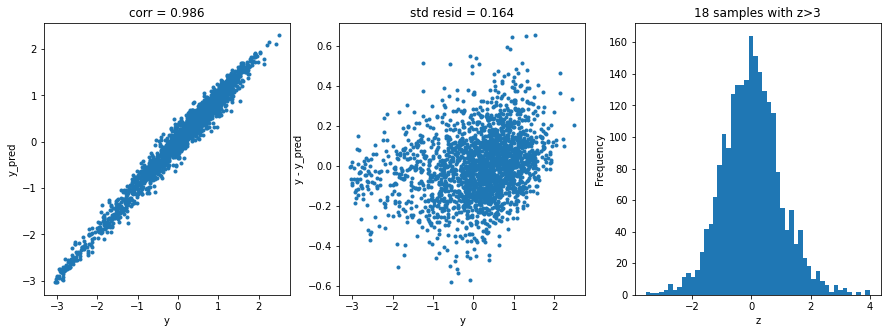

In [37]:
model = "GradientBoosting"
opt_models[model] = GradientBoostingRegressor()

param_grid = {
    "n_estimators": [150, 250, 350],
    "max_depth": [1, 2, 3],
    "min_samples_split": [5, 6, 7],
}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        splits=splits,
                                                        repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

#### XGBoost

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   28.1s finished


----------------------
XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)
----------------------
score= 0.9657808125742973
rmse= 0.1803269465116026
mse= 0.032517807638198296
cross_val: mean= 0.1035848016028502 , std= 0.00836329657703578


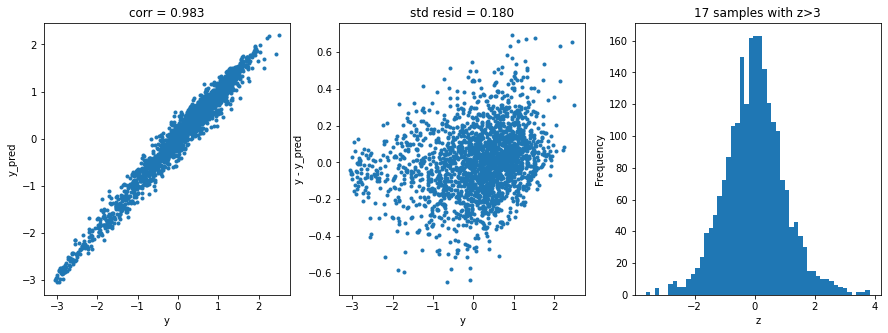

In [38]:
model = "XGB"
opt_models[model] = XGBRegressor()

param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [1, 2, 3],
}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        splits=splits,
                                                        repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

#### RandomForest

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  4.0min finished


----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=16, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
----------------------
score= 0.9833692178308959
rmse= 0.12571355857796426
mse= 0.015803898810335247
cross_val: mean= 0.10072122808638279 , std= 0.006408595722115303


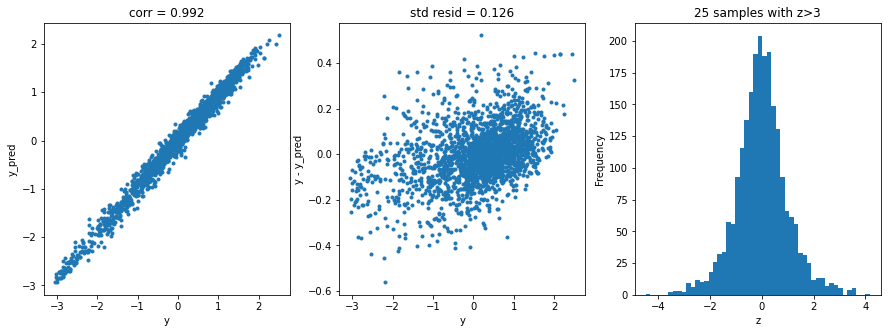

In [39]:
model = "RandomForest"
opt_models[model] = RandomForestRegressor()

param_grid = {
    "n_estimators": [100, 150, 200],
    "max_features": [8, 12, 16],
    "min_samples_split": [2, 4, 6],
}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                        param_grid=param_grid,
                                                        splits=5,
                                                        repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

### Bagging

In [71]:
def model_predict(test_data, test_y=[], filt=True, opt_models=opt_models):
    "简单平均各种模型的预测值"
    i = 0
    y_predict_total = np.zeros((test_data.shape[0],))
    for model in opt_models.keys():
        if filt and (model == "KNeighbors" or model == "LinearSVR"):
            continue
        y_predict = opt_models[model].predict(test_data)
        y_predict_total += y_predict
        i += 1
        if len(test_y) > 0:
            print("{}_mse:".format(model),
                  mean_squared_error(y_predict, test_y))
    y_predict_mean = np.round(y_predict_total / i, 3)
    if len(test_y) > 0:
        print("mean_mse:", mean_squared_error(y_predict_mean, test_y))
    else:
        y_predict_mean = pd.Series(y_predict_mean)
        return y_predict_mean

In [46]:
model_predict(X_valid, y_valid)

ridge_mse: 0.11419766554629894
lasso_mse: 0.1138124176296415
ElasticNet_mse: 0.11414340287014041
GradientBoosting_mse: 0.10511244470700407
XGB_mse: 0.10986046306651324
RandomForest_mse: 0.11360535114599894
mean_mse: 0.09905504028021016


In [47]:
results = model_predict(test)

In [48]:
# 0.1290
with open("predict_origindata.txt", "w", encoding="utf-8") as f:
    for res in results:
        f.write(str(res) + "\n")

### 将Bagging中模型输出，结合原本数据再训练 (过拟合严重)

In [74]:
def create_stack_features(data):
    features = {}
    columns = []
    for model in opt_models.keys():
        if model == "KNeighbors" or model == "LinearSVR":
            continue
        columns.append(model)
        features[model] = opt_models[model].predict(data)
    stack_feature = pd.DataFrame(features, columns=columns)
    return stack_feature

In [75]:
metal_x_train = create_stack_features(X_train)
metal_y_train = pd.Series(y_train.values)
metal_x_valid = create_stack_features(X_valid)
metal_y_valid = pd.Series(y_valid.values)
metal_x_test = create_stack_features(test)

In [76]:
metal_models = dict()
score_models = pd.DataFrame(columns=["mean", "std"])

# no. k-fold splits
splits = 5
# no. k-fold iterations
repeats = 5

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:    2.2s finished


----------------------
Ridge(alpha=0.25, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------
score= 0.9885843388225715
rmse= 0.1041540873272366
mse= 0.010848073906969603
cross_val: mean= 0.010934182044673689 , std= 0.0011926650579816799


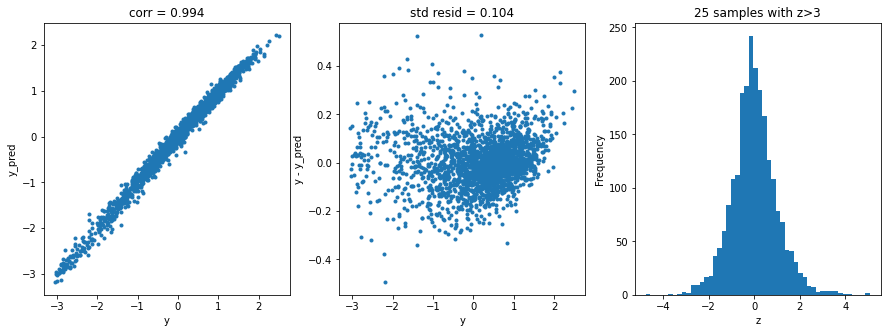

In [77]:
model = "Ridge"

metal_models[model] = Ridge()
alph_range = np.arange(0.25, 6, 0.25)
param_grid = {"alpha": alph_range}

metal_models[model], cv_score, grid_results = train_model(
    metal_models[model],
    param_grid=param_grid,
    X=metal_x_train,
    y=metal_y_train,
    splits=splits,
    repeats=repeats,
)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:   12.9s finished


----------------------
Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.9885771382854163
rmse= 0.10418693024099074
mse= 0.010854916433041073
cross_val: mean= 0.010949315239799303 , std= 0.0008727403919014737


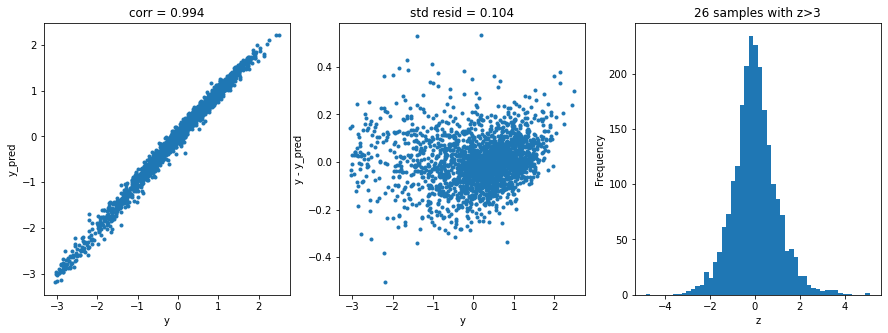

In [78]:
model = "Lasso"

metal_models[model] = Lasso()
alph_range = np.arange(1e-4, 1e-3, 4e-5)
param_grid = {"alpha": alph_range}

metal_models[model], cv_score, grid_results = train_model(
    metal_models[model],
    param_grid=param_grid,
    X=metal_x_train,
    y=metal_y_train,
    splits=splits,
    repeats=repeats,
)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:   13.3s finished


----------------------
ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.2,
      max_iter=100000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.9885850431744723
rmse= 0.10415087409850314
mse= 0.010847404575482266
cross_val: mean= 0.010885420440204048 , std= 0.0008842388076134683


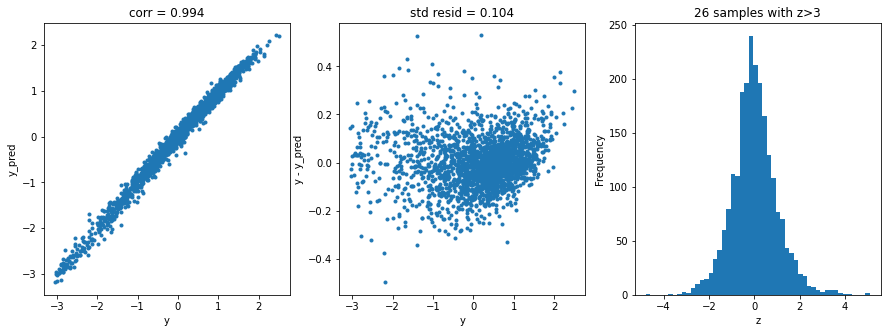

In [79]:
model = "ElasticNet"
metal_models[model] = ElasticNet()

param_grid = {
    "alpha": np.arange(1e-4, 1e-3, 1e-4),
    "l1_ratio": np.arange(0.1, 1.0, 0.1),
    "max_iter": [100000],
}

metal_models[model], cv_score, grid_results = train_model(
    metal_models[model],
    param_grid=param_grid,
    X=metal_x_train,
    y=metal_y_train,
    splits=splits,
    repeats=1,
)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   13.5s finished


----------------------
XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)
----------------------
score= 0.9943306830981428
rmse= 0.07339917008489522
mse= 0.005387438169151375
cross_val: mean= 0.011346725688383812 , std= 0.0008913657004537075


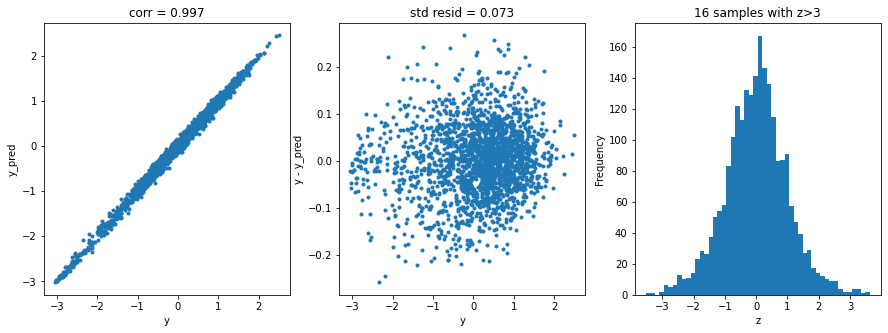

In [80]:
model = "XGB"
metal_models[model] = XGBRegressor()

param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [1, 2, 3],
}

metal_models[model], cv_score, grid_results = train_model(
    metal_models[model],
    param_grid=param_grid,
    X=metal_x_train,
    y=metal_y_train,
    splits=splits,
    repeats=1,
)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   23.8s finished


----------------------
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=7, min_weight_fraction_leaf=0.0,
             n_estimators=350, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
----------------------
score= 0.9932474805986361
rmse= 0.08010482996525163
mse= 0.006416783783761885
cross_val: mean= 0.011069652758357473 , std= 0.0006685912024722735


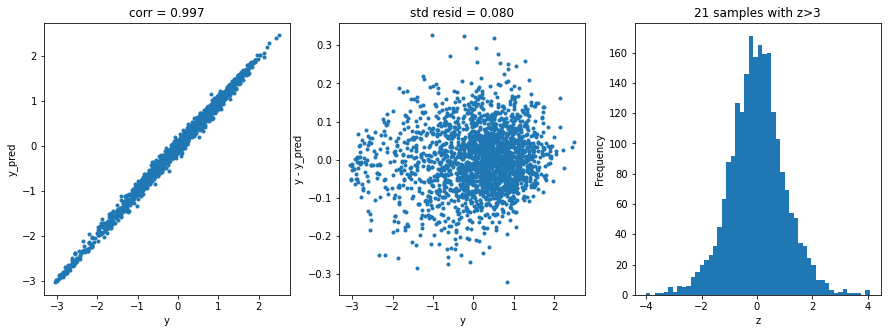

In [81]:
model = "GradientBoosting"
metal_models[model] = GradientBoostingRegressor()

param_grid = {
    "n_estimators": [150, 250, 350],
    "max_depth": [1, 2, 3],
    "min_samples_split": [5, 6, 7],
}

metal_models[model], cv_score, grid_results = train_model(
    metal_models[model],
    param_grid=param_grid,
    X=metal_x_train,
    y=metal_y_train,
    splits=splits,
    repeats=1,
)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  2.2min finished


----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=6, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
----------------------
score= 0.9971713202988364
rmse= 0.05184628818499504
mse= 0.002688037598561566
cross_val: mean= 0.011218416180496488 , std= 0.000736406744673627


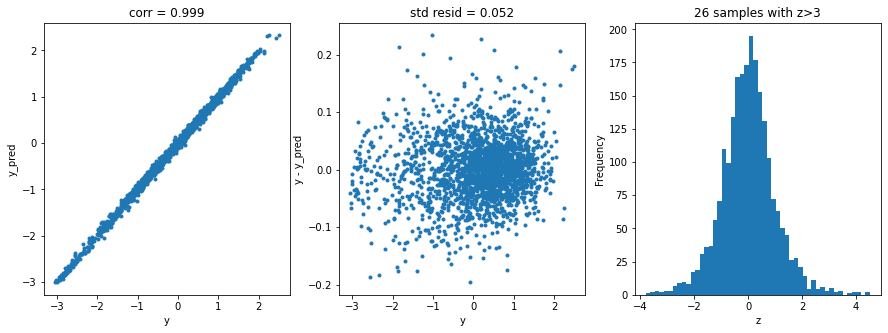

In [82]:
model = "RandomForest"
metal_models[model] = RandomForestRegressor()

param_grid = {
    "n_estimators": [100, 150, 200],
    "max_features": [2, 3, 4, 5],
    "min_samples_split": [2, 4, 6],
}

metal_models[model], cv_score, grid_results = train_model(
    metal_models[model],
    param_grid=param_grid,
    X=metal_x_train,
    y=metal_y_train,
    splits=5,
    repeats=1,
)

cv_score.name = model
score_models = score_models.append(cv_score)

In [83]:
model_predict(metal_x_valid, metal_y_valid, opt_models=metal_models)

Ridge_mse: 0.12823255870866296
Lasso_mse: 0.12829877903936773
ElasticNet_mse: 0.12826663188726017
XGB_mse: 0.12392811888182607
GradientBoosting_mse: 0.12211536960967677
RandomForest_mse: 0.12031753055821864
mean_mse: 0.12356498774080561


In [84]:
results = model_predict(metal_x_test, opt_models=metal_models)

# 0.149
with open("predict_two_bag.txt", "w", encoding="utf-8") as f:
    for res in results:
        f.write(str(res) + "\n")

### Stacking

In [86]:
import numpy as np
import pandas as pd
from scipy import sparse

import lightgbm
import xgboost
from sklearn.ensemble import (
    AdaBoostRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


def stacking_reg(clf, train_x, train_y, test_x, clf_name, kf, label_split=None):
    """对模型 clf 进行 k fold 训练，同时输出每个fold预测结果的均值"""
    train = np.zeros((train_x.shape[0], 1))
    test = np.zeros((test_x.shape[0], 1))
    test_pre = np.empty((folds, test_x.shape[0], 1))
    cv_scores = []
    for i, (train_index,
            test_index) in enumerate(kf.split(train_x, label_split)):
        tr_x = train_x[train_index]
        tr_y = train_y[train_index]
        te_x = train_x[test_index]
        te_y = train_y[test_index]
        if clf_name in ["rf", "ada", "gb", "et", "lr", "lsvc", "knn"]:
            clf.fit(tr_x, tr_y)
            pre = clf.predict(te_x).reshape(-1, 1)
            train[test_index] = pre
            test_pre[i, :] = clf.predict(test_x).reshape(-1, 1)
            cv_scores.append(mean_squared_error(te_y, pre))
        elif clf_name in ["xgb"]:
            train_matrix = clf.DMatrix(tr_x, label=tr_y, missing=-1)
            test_matrix = clf.DMatrix(te_x, label=te_y, missing=-1)
            z = clf.DMatrix(test_x, label=te_y, missing=-1)
            params = {
                "booster": "gbtree",
                "eval_metric": "rmse",
                "gamma": 1,
                "min_child_weight": 1.5,
                "max_depth": 5,
                "lambda": 10,
                "subsample": 0.7,
                "colsample_bytree": 0.7,
                "colsample_bylevel": 0.7,
                "eta": 0.03,
                "tree_method": "exact",
                "seed": 2017,
                "nthread": 12,
            }
            num_round = 10000
            early_stopping_rounds = 100
            watchlist = [(train_matrix, "train"), (test_matrix, "eval")]
            if test_matrix:
                model = clf.train(
                    params,
                    train_matrix,
                    num_boost_round=num_round,
                    evals=watchlist,
                    early_stopping_rounds=early_stopping_rounds,
                )
                pre = model.predict(test_matrix,
                                    ntree_limit=model.best_ntree_limit).reshape(
                                        -1, 1)
                train[test_index] = pre
                test_pre[i, :] = model.predict(
                    z, ntree_limit=model.best_ntree_limit).reshape(-1, 1)
                cv_scores.append(mean_squared_error(te_y, pre))

        elif clf_name in ["lgb"]:
            train_matrix = clf.Dataset(tr_x, label=tr_y)
            test_matrix = clf.Dataset(te_x, label=te_y)
            # z = clf.Dataset(test_x, label=te_y)
            # z=test_x
            params = {
                "boosting_type": "gbdt",
                "objective": "regression_l2",
                "metric": "mse",
                "min_child_weight": 1.5,
                "num_leaves": 2**5,
                "lambda_l2": 10,
                "subsample": 0.7,
                "colsample_bytree": 0.7,
                "colsample_bylevel": 0.7,
                "learning_rate": 0.03,
                "tree_method": "exact",
                "seed": 2017,
                "nthread": 12,
                "silent": True,
            }
            num_round = 10000
            early_stopping_rounds = 100
            if test_matrix:
                model = clf.train(
                    params,
                    train_matrix,
                    num_round,
                    valid_sets=test_matrix,
                    early_stopping_rounds=early_stopping_rounds,
                )
                pre = model.predict(te_x,
                                    num_iteration=model.best_iteration).reshape(
                                        -1, 1)
                train[test_index] = pre
                test_pre[i, :] = model.predict(
                    test_x, num_iteration=model.best_iteration).reshape(-1, 1)
                cv_scores.append(mean_squared_error(te_y, pre))
        else:
            raise IOError("Please add new clf.")
        print("%s now score is:" % clf_name, cv_scores)
    test[:] = test_pre.mean(axis=0)
    print("%s_score_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    return train.reshape(-1, 1), test.reshape(-1, 1)

In [87]:
# 定义不同的单模型，超参数最好先经过 搜索


def rf_reg(x_train, y_train, x_valid, kf, label_split=None):
    randomforest = RandomForestRegressor(
        n_estimators=600,
        max_depth=20,
        n_jobs=-1,
        random_state=2017,
        max_features="auto",
        verbose=1,
    )
    rf_train, rf_test = stacking_reg(randomforest,
                                     x_train,
                                     y_train,
                                     x_valid,
                                     "rf",
                                     kf,
                                     label_split=label_split)
    return rf_train, rf_test, "rf_reg"


def ada_reg(x_train, y_train, x_valid, kf, label_split=None):
    adaboost = AdaBoostRegressor(n_estimators=30,
                                 random_state=2017,
                                 learning_rate=0.01)
    ada_train, ada_test = stacking_reg(adaboost,
                                       x_train,
                                       y_train,
                                       x_valid,
                                       "ada",
                                       kf,
                                       label_split=label_split)
    return ada_train, ada_test, "ada_reg"


def gb_reg(x_train, y_train, x_valid, kf, label_split=None):
    gbdt = GradientBoostingRegressor(
        learning_rate=0.04,
        n_estimators=100,
        subsample=0.8,
        random_state=2017,
        max_depth=5,
        verbose=1,
    )
    gbdt_train, gbdt_test = stacking_reg(gbdt,
                                         x_train,
                                         y_train,
                                         x_valid,
                                         "gb",
                                         kf,
                                         label_split=label_split)
    return gbdt_train, gbdt_test, "gb_reg"


def et_reg(x_train, y_train, x_valid, kf, label_split=None):
    extratree = ExtraTreesRegressor(
        n_estimators=600,
        max_depth=35,
        max_features="auto",
        n_jobs=-1,
        random_state=2017,
        verbose=1,
    )
    et_train, et_test = stacking_reg(extratree,
                                     x_train,
                                     y_train,
                                     x_valid,
                                     "et",
                                     kf,
                                     label_split=label_split)
    return et_train, et_test, "et_reg"


def lr_reg(x_train, y_train, x_valid, kf, label_split=None):
    lr_reg = LinearRegression(n_jobs=-1)
    lr_train, lr_test = stacking_reg(lr_reg,
                                     x_train,
                                     y_train,
                                     x_valid,
                                     "lr",
                                     kf,
                                     label_split=label_split)
    return lr_train, lr_test, "lr_reg"


def xgb_reg(x_train, y_train, x_valid, kf, label_split=None):
    xgb_train, xgb_test = stacking_reg(xgboost,
                                       x_train,
                                       y_train,
                                       x_valid,
                                       "xgb",
                                       kf,
                                       label_split=label_split)
    return xgb_train, xgb_test, "xgb_reg"


def lgb_reg(x_train, y_train, x_valid, kf, label_split=None):
    lgb_train, lgb_test = stacking_reg(lightgbm,
                                       x_train,
                                       y_train,
                                       x_valid,
                                       "lgb",
                                       kf,
                                       label_split=label_split)
    return lgb_train, lgb_test, "lgb_reg"

In [100]:
def stacking_pred(
    x_train,
    y_train,
    x_valid,
    kf,
    clf_list,
    label_split=None,
    clf_fin="lgb",
    if_concat_origin=True,
):
    """将原数据，与第一阶段分类器的预测结果，作为第二阶段clf_fin的输入，训练stacking模型
    注意输入数据，必须为numpy array。
    容易过拟合
    """
    for k, clf_list in enumerate(clf_list):
        clf_list = [clf_list]
        column_list = []
        train_data_list = []
        test_data_list = []
        for clf in clf_list:
            train_data, test_data, clf_name = clf(x_train,
                                                  y_train,
                                                  x_valid,
                                                  kf,
                                                  label_split=label_split)
            train_data_list.append(train_data)
            test_data_list.append(test_data)
            column_list.append("clf_%s" % (clf_name))
    train = np.concatenate(train_data_list, axis=1)
    test = np.concatenate(test_data_list, axis=1)

    if if_concat_origin:
        train = np.concatenate([x_train, train], axis=1)
        test = np.concatenate([x_valid, test], axis=1)
    print(x_train.shape)
    print(train.shape)
    print(clf_name)
    print(clf_name in ["lgb"])
    if clf_fin in ["rf", "ada", "gb", "et", "lr", "lsvc", "knn"]:
        if clf_fin in ["rf"]:
            clf = RandomForestRegressor(
                n_estimators=600,
                max_depth=20,
                n_jobs=-1,
                random_state=2017,
                max_features="auto",
                verbose=1,
            )
        elif clf_fin in ["ada"]:
            clf = AdaBoostRegressor(n_estimators=30,
                                    random_state=2017,
                                    learning_rate=0.01)
        elif clf_fin in ["gb"]:
            clf = GradientBoostingRegressor(
                learning_rate=0.04,
                n_estimators=100,
                subsample=0.8,
                random_state=2017,
                max_depth=5,
                verbose=1,
            )
        elif clf_fin in ["et"]:
            clf = ExtraTreesRegressor(
                n_estimators=600,
                max_depth=35,
                max_features="auto",
                n_jobs=-1,
                random_state=2017,
                verbose=1,
            )
        elif clf_fin in ["lr"]:
            clf = LinearRegression(n_jobs=-1)
        clf.fit(train, y_train)
        pre = clf.predict(test).reshape(-1, 1)
        return pred
    elif clf_fin in ["xgb"]:
        clf = xgboost
        train_matrix = clf.DMatrix(train, label=y_train, missing=-1)
        test_matrix = clf.DMatrix(train, label=y_train, missing=-1)
        params = {
            "booster": "gbtree",
            "eval_metric": "rmse",
            "gamma": 1,
            "min_child_weight": 1.5,
            "max_depth": 5,
            "lambda": 10,
            "subsample": 0.7,
            "colsample_bytree": 0.7,
            "colsample_bylevel": 0.7,
            "eta": 0.03,
            "tree_method": "exact",
            "seed": 2017,
            "nthread": 12,
        }
        num_round = 10000
        early_stopping_rounds = 100
        watchlist = [(train_matrix, "train"), (test_matrix, "eval")]
        model = clf.train(
            params,
            train_matrix,
            num_boost_round=num_round,
            evals=watchlist,
            early_stopping_rounds=early_stopping_rounds,
        )
        pre = model.predict(test,
                            ntree_limit=model.best_ntree_limit).reshape(-1, 1)
        return pre
    elif clf_fin in ["lgb"]:
        print(clf_name)
        clf = lightgbm
        train_matrix = clf.Dataset(train, label=y_train)
        test_matrix = clf.Dataset(train, label=y_train)
        params = {
            "boosting_type": "gbdt",
            "objective": "regression_l2",
            "metric": "mse",
            "min_child_weight": 1.5,
            "num_leaves": 2**5,
            "lambda_l2": 10,
            "subsample": 0.7,
            "colsample_bytree": 0.7,
            "colsample_bylevel": 0.7,
            "learning_rate": 0.03,
            "tree_method": "exact",
            "seed": 2017,
            "nthread": 12,
            "silent": True,
        }
        num_round = 10000
        early_stopping_rounds = 100
        model = clf.train(
            params,
            train_matrix,
            num_round,
            valid_sets=test_matrix,
            early_stopping_rounds=early_stopping_rounds,
        )
        # print("pred")
        pre = model.predict(test,
                            num_iteration=model.best_iteration).reshape(-1, 1)
        # print(pre)
        return pre

In [97]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=0)

folds = 5
clf_list = [lr_reg, lgb_reg]

pred = stacking_pred(
    X_train.values,
    y_train.values,
    test.values,
    kf,
    clf_list,
    label_split=None,
    clf_fin="lgb",
    if_concat_origin=True,
)

lr now score is: [0.11425410211413932]
lr now score is: [0.11425410211413932, 0.10354292422393652]
lr now score is: [0.11425410211413932, 0.10354292422393652, 0.11774562550804858]
lr now score is: [0.11425410211413932, 0.10354292422393652, 0.11774562550804858, 0.09521792168502646]
lr now score is: [0.11425410211413932, 0.10354292422393652, 0.11774562550804858, 0.09521792168502646, 0.10725924768629318]
lr_score_list: [0.11425410211413932, 0.10354292422393652, 0.11774562550804858, 0.09521792168502646, 0.10725924768629318]
lr_score_mean: 0.10760396424348881
[1]	valid_0's l2: 0.910558
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.868259
[3]	valid_0's l2: 0.828075
[4]	valid_0's l2: 0.790687
[5]	valid_0's l2: 0.755478
[6]	valid_0's l2: 0.721585
[7]	valid_0's l2: 0.689827
[8]	valid_0's l2: 0.659469
[9]	valid_0's l2: 0.630905
[10]	valid_0's l2: 0.603771
[11]	valid_0's l2: 0.578539
[12]	valid_0's l2: 0.554899
[13]	valid_0's l2: 0.532251
[14]	valid_0's l2: 0.5

In [98]:
# 0.149
with open("predict_stacking.txt", "w", encoding="utf-8") as f:
    for res in pred:
        f.write(str(res[0]) + "\n")

### 结合多层神经网络的开源方案

In [109]:
import math
import os
from datetime import datetime

import keras
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.wrappers.scikit_learn import KerasRegressor
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm, skew

import lightgbm
import xgboost
from lightgbm import LGBMRegressor
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone
from sklearn.decomposition import pca
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import (
    BayesianRidge,
    ElasticNet,
    Lasso,
    LassoLarsIC,
    LinearRegression,
)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor

seed = 2018

In [110]:
# Stacking
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):

    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def fit(self, X, y):
        # list()：表示base model也有可能是一组模型的组合
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)  # 创建相同参数的模型，但是还没有fit
        kfold = KFold(n_splits=self.n_folds, shuffle=True)

        # 将每个模型在k fold时的预测结果记录下来，作为meta_model_的输入，再训练
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(clf)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # 将多模型预测结果，作为meta model的输入，再训练
        print(out_of_fold_predictions.shape)
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    def predict(self, X):
        # 第一阶段模型预测
        meta_features = np.column_stack([
            np.column_stack([model.predict(X)
                             for model in base_models]).mean(axis=1)
            for base_models in self.base_models_
        ])
        # 第二阶段模型预测
        return self.meta_model_.predict(meta_features)

In [111]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    "多模型直接average，相比于stacking，过拟合不会那么严重"

    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        predictions = np.column_stack(
            [model.predict(X) for model in self.models_])
        # 可对多种模型进行加权
        # return 0.85*predictions[:,0]+0.15*predictions[:,1]
        # return 0.7*predictions[:,0]+0.15*predictions[:,1]+0.15*predictions[:,2]
        return np.mean(predictions, axis=1)

In [113]:
def load_train_data(use_full_data=True, remove_outlier=True):
    df = pd.read_csv("zhengqi_train.txt", header=0, sep="\s+")
    if remove_outlier:
        # find and remove outliers using a Ridge model
        outliers = find_outliers(Ridge(), df.iloc[:, 0:-1], df.iloc[:, -1])
        # permanently remove these outliers from the data
        df.drop(outliers, inplace=True)
        df.reset_index(inplace=True, drop=True)

    X = df.drop(columns=["target"])
    y = df["target"]
    print("X shape:", X.shape)
    print("y shape", y.shape)

    if not use_full_data:  # 准备验证集，调参使用
        X_train, X_val, y_train, y_val = train_test_split(X,
                                                          y,
                                                          test_size=0.2,
                                                          random_state=1)
        print("X_train shape:", X_train.shape)
        print("y_train shape:", y_train.shape)
        print("X_val shape:", X_val.shape)
        print("y_val shape:", y_val.shape)
        return X_train, X_val, y_train, y_val
    else:  # 全量数据训练，最终模型拟合使用
        return X, y


def load_test_data():
    df = pd.read_csv("zhengqi_test.txt", header=0, sep="\s+")
    X_test = df
    return X_test


def build_nn():
    model = Sequential()
    model.add(Dense(units=128, activation="linear", input_dim=18))
    model.add(Dense(units=32, activation="linear"))
    model.add(Dense(units=8, activation="linear"))
    model.add(Dense(units=1, activation="linear"))
    model.compile(loss="mse", optimizer="adam")
    return model


def build_model():
    svr = make_pipeline(SVR(kernel="linear"))
    line = make_pipeline(LinearRegression())
    lasso = make_pipeline(Lasso(alpha=0.0005, random_state=1))
    ENet = make_pipeline(ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=3))
    KRR1 = KernelRidge(alpha=0.6, kernel="polynomial", degree=2, coef0=2.5)
    KRR2 = KernelRidge(alpha=1.5, kernel="linear", degree=2, coef0=2.5)
    lgbm = lightgbm.LGBMRegressor(learning_rate=0.01,
                                  n_estimators=500,
                                  num_leaves=31)
    xgb = xgboost.XGBRegressor(
        booster="gbtree",
        colsample_bytree=0.8,
        gamma=0.1,
        learning_rate=0.02,
        max_depth=5,
        n_estimators=500,
        min_child_weight=0.8,
        reg_alpha=0,
        reg_lambda=1,
        subsample=0.8,
        silent=1,
        random_state=seed,
        nthread=2,
    )
    nn = KerasRegressor(build_fn=build_nn,
                        nb_epoch=500,
                        batch_size=32,
                        verbose=2)
    return svr, line, lasso, ENet, KRR1, KRR2, lgbm, xgb, nn


def rmsle_cv(model=None, X_train_head=None, y_train=None):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True,
               random_state=seed).get_n_splits(X_train_head)
    rmse = -cross_val_score(
        model, X_train_head, y_train, scoring="neg_mean_squared_error", cv=kf)
    return rmse

In [114]:
FINAL_TRAIN = True

Load data from file......
R2= 0.8890858938210386
rmse= 0.3276409280465989
mse= 0.10734857773123632
---------------------------------------
mean of residuals: 6.3430332085578545e-18
std of residuals: 0.32769766731935024
---------------------------------------
31 outliers:
[321, 348, 376, 777, 884, 1145, 1164, 1310, 1458, 1466, 1484, 1523, 1704, 1874, 1879, 1979, 2002, 2279, 2528, 2620, 2645, 2647, 2667, 2668, 2669, 2696, 2767, 2769, 2807, 2842, 2863]
X shape: (2857, 38)
y shape (2857,)
X_train shape (2857, 38)
X_test shape (1925, 38)
y_train shape (2857,)
all data shape (4782, 38)
Load done.


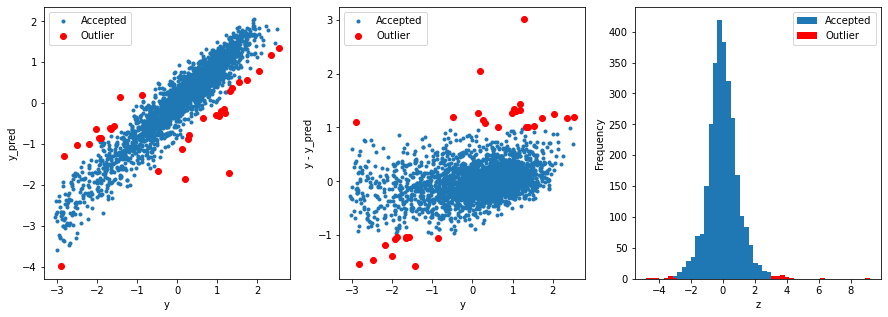

In [116]:
# =============加载数据=============
print("Load data from file......")
X_test = load_test_data()
if FINAL_TRAIN:
    X_train, y_train = load_train_data(True, remove_outlier=True)
    all_data = pd.concat([X_train, X_test])
else:
    X_train, X_val, y_train, y_val = load_train_data(False, remove_outlier=True)
    all_data = pd.concat([X_train, X_val, X_test])
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("all data shape", all_data.shape)
print("Load done.")

In [117]:
# =============无关特征删除=============
all_data = all_data.drop(["V5", "V9", "V11", "V17", "V22", "V28"], axis=1)
print(all_data.shape)
print("Drop done.")

(4782, 32)
Drop done.


In [118]:
# =============标准化=============
from sklearn import preprocessing

scaler = MinMaxScaler(feature_range=(0, 1))
all_data = pd.DataFrame(scaler.fit_transform(all_data),
                        columns=all_data.columns)
# print("缩放后的describe", all_data.describe())
print("Scale done.")

Scale done.


In [119]:
# =============偏态处理=============
# # 检测数据的偏度，过大时，进行boxcox变换
# skewed_feats = all_data.apply(lambda x: skew(x.dropna())).sort_values(ascending=True)
# print("\nSkew in numerical features: \n", skewed_feats)
# skewness = pd.DataFrame({'Skew' :skewed_feats})
# print(skewness.head(15))
# skewness = skewness[abs(skewness) > 0.75]
# print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
# print("y skew:", skew(y_train))

# # boxcox变换
# from scipy.special import boxcox1p
# skewed_features = skewness.dropna().index
# lam = 0.15
# for feat in skewed_features:
# all_data[feat] += 1
#    all_data[feat] = boxcox1p(all_data[feat], lam)
# all_data = pd.get_dummies(all_data)
# print(all_data.shape)
# X_train = all_data[:len(X_train)]
# X_test = all_data[len(X_train):]

In [120]:
# =============数据正态性处理=============
# # 和boxcox变换的目的一致，使数据保持标准正态性
# # 实验选择处理的特征
all_data["V0"] = all_data["V0"].apply(lambda x: math.exp(x))
all_data["V1"] = all_data["V1"].apply(lambda x: math.exp(x))
# all_data['V4'] = all_data['V4'].apply(lambda x:math.exp(x))
all_data["V6"] = all_data["V6"].apply(lambda x: math.exp(x))
all_data["V7"] = all_data["V7"].apply(lambda x: math.exp(x))
all_data["V8"] = all_data["V8"].apply(lambda x: math.exp(x))
# all_data['V12'] = all_data['V12'].apply(lambda x:math.exp(x))
# all_data['V16'] = all_data['V16'].apply(lambda x:math.exp(x))
# all_data['V26'] = all_data['V26'].apply(lambda x:math.exp(x))
# all_data['V27'] = all_data['V27'].apply(lambda x:math.exp(x))
all_data["V30"] = np.log1p(all_data["V30"])
# all_data["V31"] = np.log1p(all_data["V31"])
# all_data["V32"] = np.log1p(all_data["V32"])

scaled = pd.DataFrame(preprocessing.scale(all_data), columns=all_data.columns)
X_train = scaled.loc[0:len(X_train) - 1]
X_test = scaled.loc[len(X_train):]

print("Skewness done.")
print("偏态处理后的shape", X_train.shape, X_test.shape, y_train.shape)

Skewness done.
偏态处理后的shape (2857, 32) (1925, 32) (2857,)


In [121]:
# =============特征选择=============
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression

# 方差筛选
threshold = 0.85
vt = VarianceThreshold().fit(X_train)
# Find feature names
feat_var_threshold = X_train.columns[vt.variances_ > threshold *
                                     (1 - threshold)]
X_train = X_train[feat_var_threshold]
X_test = X_test[feat_var_threshold]
all_data = pd.concat([X_train, X_test])
print("方差筛选后的shape", all_data.shape)

# 单变量酾浚
X_scored = SelectKBest(score_func=f_regression, k="all").fit(X_train, y_train)
feature_scoring = pd.DataFrame({
    "feature": X_train.columns,
    "score": X_scored.scores_
})
head_feature_num = 18
feat_scored_headnum = feature_scoring.sort_values(
    "score", ascending=False).head(head_feature_num)["feature"]
X_train_head = X_train[X_train.columns[X_train.columns.isin(
    feat_scored_headnum)]]

X_test_head = X_test[X_test.columns[X_test.columns.isin(feat_scored_headnum)]]
print("单变量选择后的shape")
print(X_train_head.shape)
print(y_train.shape)
print(X_test_head.shape)

# # 实验xgboost模型时使用 X_train_head_22
# head_feature_num = 22
# feat_scored_headnum = feature_scoring.sort_values(
#     "score", ascending=False).head(head_feature_num)["feature"]
# X_train_head_22 = X_train[X_train.columns[X_train.columns.isin(
#     feat_scored_headnum)]]

方差筛选后的shape (4782, 31)
单变量选择后的shape
(2857, 18)
(2857,)
(1925, 18)


In [138]:
vt.variances_

array([0.89575244, 0.89928312, 0.82637762, 0.93959501, 0.7851983 ,
       0.89101139, 0.96067629, 0.84498704, 0.92949114, 0.79566505,
       0.84753842, 1.0330974 , 1.06204641, 0.95969995, 0.90167853,
       1.23094587, 0.62043901, 0.60809601, 0.9439405 , 1.06729577,
       0.83575351, 0.79075513, 0.07228735, 1.12177132, 0.77433126,
       0.75353176, 0.80422606, 1.0149707 , 1.0078805 , 0.96710702,
       0.93251192, 1.03156428])

In [140]:
feature_scoring.sort_values(
    "score", ascending=False)

,feature,score
0,V0,10335.021432
1,V1,10325.278572
7,V8,7007.527363
24,V31,3967.852876
2,V2,2048.694430
4,V4,1666.538046
9,V12,1571.782633
30,V37,1375.212949
13,V16,1216.366468
3,V3,1023.916917


In [122]:
print("Start training......")
svr, line, lasso, ENet, KRR1, KRR2, lgbm, xgb, nn = build_model()
train_start = datetime.now()

score = rmsle_cv(svr, X_train_head, y_train)
print("SVR 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(line, X_train_head, y_train)
print("Line 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(lasso, X_train_head, y_train)
print("Lasso 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet, X_train_head, y_train)
print("ElasticNet 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR1, X_train_head, y_train)
print("Kernel Ridge1 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR2, X_train_head, y_train)
print("Kernel Ridge2 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(xgb, X_train_head, y_train)
print("Xgboost 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(lgbm, X_train_head, y_train)
print("LGBM 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(nn, X_train_head, y_train)
print("NN 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

train_end = datetime.now()
print("spend time:" + str((train_end - train_start).seconds) + "(s)")

Start training......
SVR 得分: 0.1080 (0.0188)

Line 得分: 0.1096 (0.0172)

Lasso 得分: 0.1093 (0.0175)

ElasticNet 得分: 0.1093 (0.0175)

Kernel Ridge1 得分: 0.1114 (0.0130)

Kernel Ridge2 得分: 0.1083 (0.0173)

Xgboost 得分: 0.1129 (0.0202)

LGBM 得分: 0.1146 (0.0187)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/1
 - 1s - loss: 0.2820
Epoch 1/1
 - 0s - loss: 0.2275
Epoch 1/1
 - 0s - loss: 0.1713
Epoch 1/1
 - 0s - loss: 0.1914
Epoch 1/1
 - 0s - loss: 0.2070
NN 得分: 0.1252 (0.0184)

spend time:44(s)


In [141]:
print("Start training......")
train_start = datetime.now()

# 选择要使用的模型训练
svr.fit(X_train_head, y_train)
ENet.fit(X_train_head, y_train)
KRR1.fit(X_train_head, y_train)
lgbm.fit(X_train_head, y_train)
xgb.fit(X_train_head, y_train)
# nn.fit(X_train_head, y_train)

averaged_models = AveragingModels(models=(svr, ENet, KRR1, lgbm, xgb))

score = rmsle_cv(averaged_models, X_train_head, y_train)
print("对基模型集成后的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# 再训练
averaged_models.fit(X_train_head, y_train)

# 容易过拟合
# stacking_models = StackingAveragedModels(base_models=(svr,KRR2,nn), meta_model=xgb)
# stacking_models.fit(X_train_head.values, y_train.values)
# stacked_train_pred = stacking_models.predict(X_train_head)
# score = mean_squared_error(y_train.values, stacked_train_pred)
# print("Stacking Averaged models predict score: {:.4f}".format(score))

train_end = datetime.now()
print("spend time:" + str((train_end - train_start).seconds) + "(s)")

Start training......
对基模型集成后的得分: 0.1019 (0.0173)

spend time:33(s)


In [134]:
print("Predict......")

# X_test = pd.DataFrame(pca_.transform(X_test))
# X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

y_pred = averaged_models.predict(X_test_head)
result = pd.DataFrame(y_pred)
result.to_csv("average_result.txt", index=False, header=False)

print("Predict Done.")
# print(datetime.now())

Predict......
Predict Done.


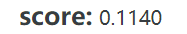

线上得分 0.1140